In [2]:
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import seaborn as sns
import charts_function_list
_,data,outputs = charts_function_list.folder_setup()

In [10]:
ls

ALL_NBA_team.csv
Bed_Size.png
Boardgames.png
DC_film_comparison.png
DC_film_comparison_.png
Metric_Bed.png
Monuments.png
Poke Count.png
Population Comparison.png
Population Comparison_metro_sort.png
Population Comparison_percent_diff_sort.png
Population Comparison_ratio_sort.png
US_Bed.png
dog_intelligence.png
lil_rappers.png
lots_of_sequels.png
lots_of_sequels_std.png
mar_a_lago_drop.png
movie_list_interim.csv
tallest_us_2021.png


In [227]:
empty = []

url = "https://www.basketball-reference.com/teams/WAS"
html = urlopen(url) #get_request
soup = BeautifulSoup(html,"lxml") 

column_headers = [th.getText() for th in 
                  soup.findAll('tr', limit=2)[0].findAll('th')]

for i,v in enumerate(['WAS','MIL','TOR','ORL','MIA',
            'CLE','NJN','DET','CHA','IND',
             'BOS','ATL','PHI','NYK','CHI',
             'LAC','SAS','MEM','HOU',
             'MIN','POR','UTA','GSW','OKC',
             'NOH','LAL','DEN','PHO','SAC','DAL']):
    url = "https://www.basketball-reference.com/teams/"+v
    html = urlopen(url) #get_request
    soup = BeautifulSoup(html,"lxml") #load into beuatiful soup
    
    table_rows = soup.select('#'+v+' tr')[2:] #selecting table row elements from within Team css selector
    data = extract_player_data(table_rows)
    empty.append(pd.DataFrame(data, columns=column_headers,index=[i for x in range(len(data))]))

all_nba = pd.concat(empty)
all_nba['Team']=all_nba['Team'].str.strip('*')
all_nba['W/L%'] = all_nba['W/L%'].astype('float')

os.chdir('/Users/alexanderpudlin/Documents/GitHub/charts_and_more_charts/outputs')
all_nba.to_csv('ALL_NBA_team.csv')

### Post scraping

In [100]:
os.chdir(outputs)
all_nba = pd.read_csv('ALL_NBA_team.csv',index_col=0)
all_nba = all_nba[all_nba['Lg']=='NBA']
team_dictionary = dict(all_nba[~all_nba.index.duplicated(keep='first')]['Team'])
all_nba['Current Team'] = pd.Series(all_nba.index).map(team_dictionary).values
med_win_percent_group = all_nba.groupby('Current Team').median().sort_values(by='W/L%',ascending=False)
med_win_percent_group['Team Order']=[i+1 for i,v in enumerate(med_win_percent_group.index)]
all_nba['Median Win Percent Index']=all_nba['Current Team'].map(dict(med_win_percent_group['Team Order']))
all_nba = all_nba.sort_values(by=['Median Win Percent Index','Season'])

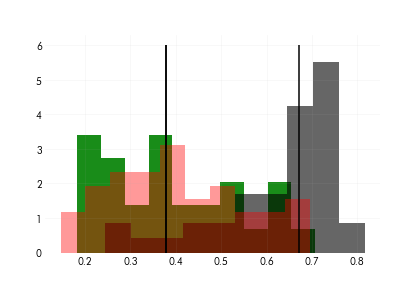

In [277]:
#juxtaposition fun .. maybe resume something with this
for item in [['Minnesota Timberwolves','green',.9],
             ['San Antonio Spurs','black',.6],
            ['Los Angeles Clippers','red',.4]]:
    plt.hist(all_nba[all_nba['Current Team']==item[0]]['W/L%'],normed=True,color=item[1],alpha=item[2])
    plt.vlines(all_nba[all_nba['Current Team']==item[0]]['W/L%'].median(),ymin=0,ymax=6)
    #plt.hist(all_nba[all_nba['Current Team']=='Los Angeles Clippers']['W/L%'],color='green',alpha=.6,normed=True)
#plt.hist(all_nba[all_nba['Current Team']=='San Antonio Spurs']['W/L%'],color='black',alpha=.6,normed=True)
#plt.vlines(all_nba[all_nba['Current Team']=='Dallas Mavericks']['W/L%'].median(),
   #       ymin=0,ymax=1)

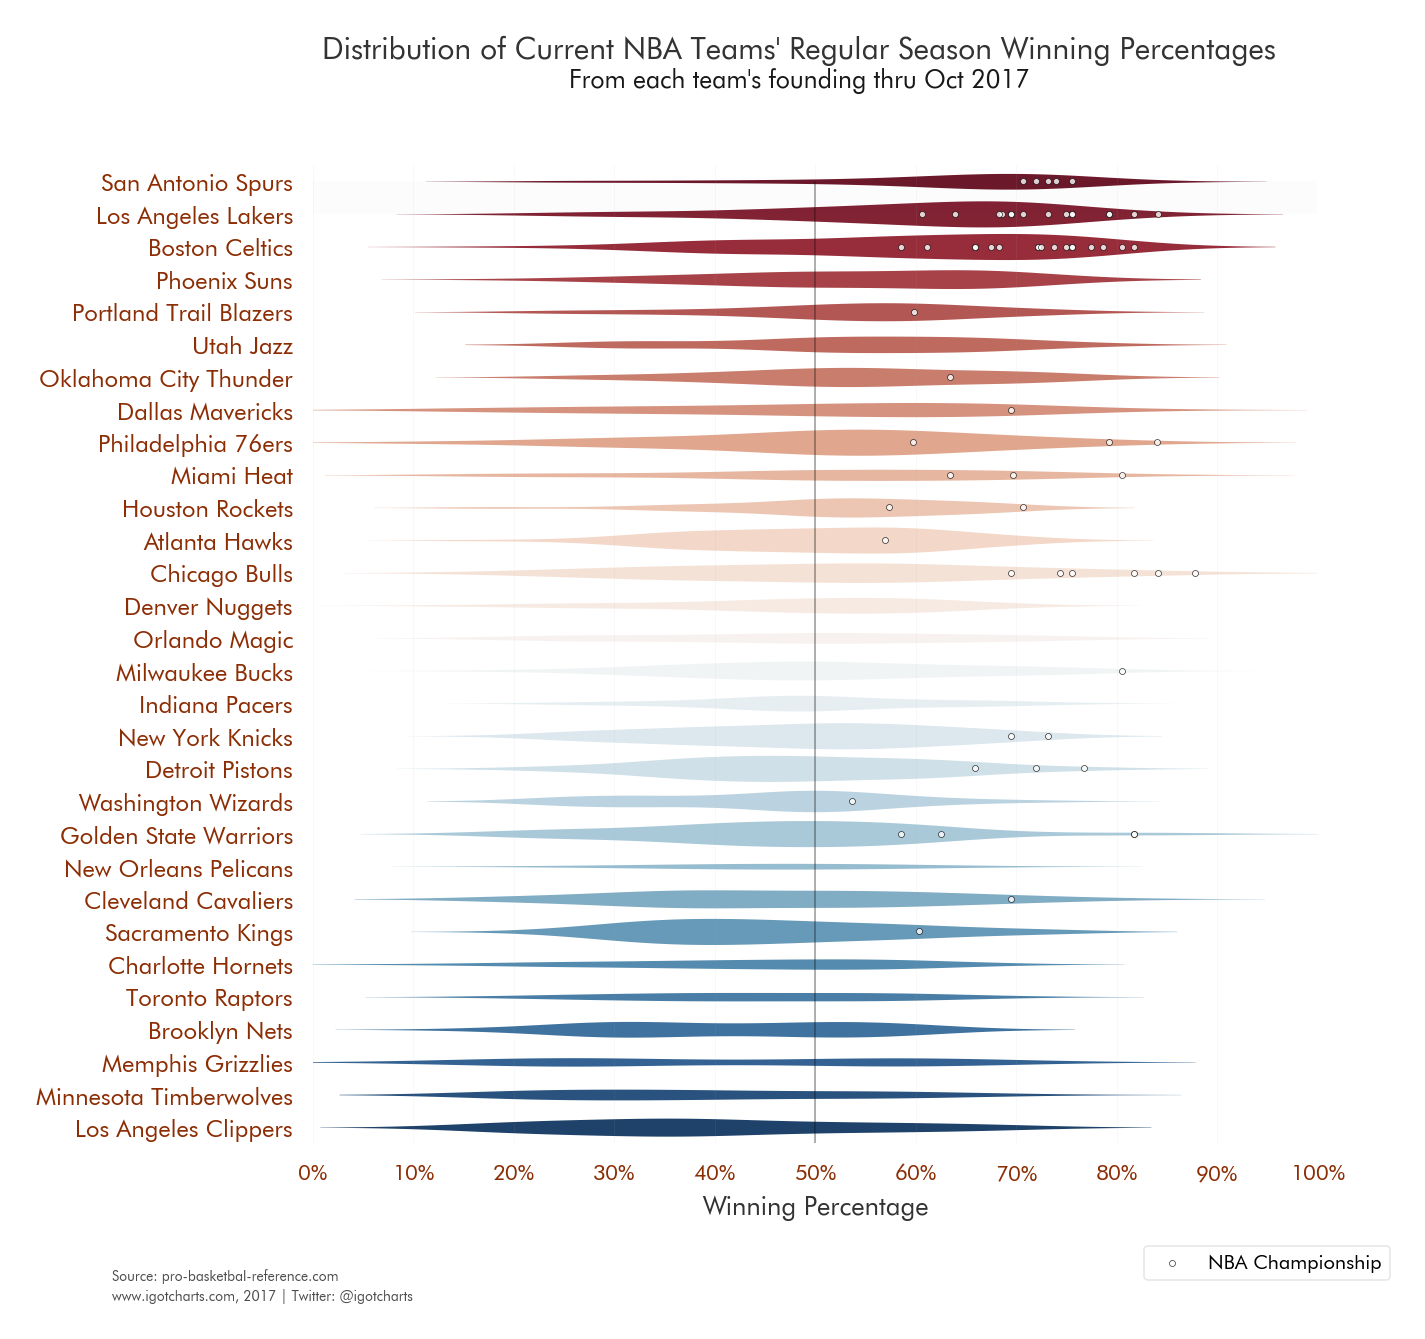

In [328]:
#New dataframe
winners = all_nba[all_nba['Playoffs']=='Won Finals']


plt.rcParams["font.family"]='Futura Bk BT'
chart_setup = charts_function_list.chart_maker(title='Distribution of Current NBA Teams\' Regular Season Winning Percentages\n',                                              title_size=30)

#FIGURE
fig = chart_setup.initial_fig_axis(figsize=(18,18))

fig.text(.5,.94,'From each team\'s founding thru Oct 2017',
         fontsize=25,alpha=.9,ha='center')

#AXES
ax = chart_setup.axes_set_up(fig=fig)

#PLOTS
sns.violinplot(x='W/L%',y='Current Team',data=all_nba,
               palette='RdBu',linewidth=0,
               scale='count',saturation=.7)

plt.scatter(y=winners['Median Win Percent Index']-1,
            x=winners['W/L%'],color='white',edgecolor='black',
            marker='o',linewidth=.7,alpha=.8,label='NBA Championship')

ax.vlines(.5,ymin=0,ymax=30,color='black',alpha=.4)


#LABELS
ax.set_xlabel('Winning Percentage',fontsize=26,alpha=.8)
ax.set_ylabel('',fontsize=26,alpha=.8)
chart_setup.x_axis_setup(ax,0,1,interval=.1)
chart_setup.tick_params_(ax=ax,labelcolor='#8c2d04',pad=20,fontsize=18)
ax_text_y = ax.set_yticklabels(all_nba.sort_values(by='Median Win Percent Index')['Current Team'].unique(),rotation=0,fontsize=24)
ax_text_x = ax.set_xticklabels([str(int(x*100))+'%' for x in ax.get_xticks()],fontsize=22)


#PATCH
patch = ax.add_patch(patches.Rectangle(xy=(0,0), width=40,height=1,facecolor='black',alpha=.01,zorder=1))



#LEGEND
leg = ax.legend(bbox_to_anchor=(.95, -.15),loc=8,
          frameon=True,facecolor='None',
          edgecolor='black',fontsize=20)

leg.get_frame().set_linewidth(1.5)
leg.get_frame().set_alpha(.1)



#CITATIONS
chart_setup.citations(ax=ax,source='Source: pro-basketbal-reference.com',x=-.2,source_y=-.14,chart_tag_y=-.16,alpha=.7)

#SAVE
os.chdir(outputs)
plt.savefig('NBA distribution.png',bbox_inches = 'tight', dpi = 160, pad_inches = .5,transparent=False)




In [168]:
def extract_player_data(table_rows):
    """
    Extract and return the the desired information from the td elements within
    the table rows.
    """
    # create the empty list to store the player data
    player_data = []
    
    for row in table_rows:  # for each row do the following

        
        player_list = [th.get_text() for th in row.find_all("th")]+[td.get_text() for td in row.find_all("td")]

        if not player_list:
            continue

        player_data.append(player_list)
        
    return player_data

In [216]:
#noted that frame did not return data for all teams. To investigate:

empty_dict = {}

for i,v in enumerate(['WAS','MIL','TOR','ORL','MIA',
            'CLE','BRK','DET','CHO','IND',
             'BOS','ATL','PHI','NYK','CHI',
             'LAC','SAS','MEM','HOU',
             'MIN','POR','UTA','GSW','OKC',
             'NOP','LAL','DEN','PHO','SAC','DAL']):
    empty_dict[i] = v

def match_lookup():    
    non_match_keys = [x for x in set(empty_dict.keys()) if x not in all_nba.index.value_counts().sort_index().index]
    return non_match_keys 
    #if len(non_match_keys)>0:
     #   return [empty_dict[x] for x in [x for x in non_match_keys]]
    #else:
     #   return 'All keys match'

#more research shows URL forwarding

#NOP's ID is NOH
#BRK's ID is NJN
#CHO's ID is CHA

In [208]:
#non_match_keys = [x for x in set(empty_dict.keys()) if x not in all_nba.index.value_counts().sort_index().index]
#non_match_values = [empty_dict[x] for x in [x for x in non_match_keys]]
#non_match_values

['CHO']